In [1]:
# Following : http://li.mit.edu/A/Papers/03/Cai03.pdf

In [2]:
import pyiron_continuum

In [26]:
from pyiron_atomistics import Project
from pyiron_continuum import Project as ProjectContinuum
import numpy as np
import matplotlib.pylab as plt

pr = Project('binding_energy')
pr_c = ProjectContinuum('.')

GPa_to_eVA3 = 160.2

potential = '2009--Bonny-G--Fe-Ni--LAMMPS--ipr1'

def get_bulk(potential=potential, pr=pr):
    lmp = pr.create.job.Lammps('bulk')
    lmp.structure = pr.create.structure.bulk('Fe', cubic=True)
    lmp.potential = potential
    lmp.calc_minimize(pressure=0)
    if lmp.status.initialized:
        lmp.run()
    return lmp.get_structure()

def get_dipole_tensor(n_repeat=3, potential=potential, pr=pr, GPa_to_eVA3=GPa_to_eVA3):
    lmp = pr.create.job.Lammps('dipole_tensor')
    lmp.structure = get_bulk()
    lmp.structure[0] = 'Ni'
    lmp.calc_minimize()
    if lmp.status.initialized:
        lmp.run()
    return -lmp.structure.get_volume()*lmp.output.pressures[-1]/GPa_to_eVA3

def get_elastic_tensor(potential=potential, pr=pr, GPa_to_eVA3=GPa_to_eVA3):
    lmp = pr.create.job.Lammps('lmp_elastic_tensor')
    lmp.structure = get_bulk()
    lmp.potential = potential
    lmp.interactive_open()
    elast = lmp.create_job('ElasticTensor', 'elastic_tensor')
    if elast.status.initialized:
        elast.run()
    return elast['output/elastic_tensor']/GPa_to_eVA3

burgers_vector = np.sqrt(3)/2*get_bulk().cell[0,0]

n = 100
lim = 5
span = np.linspace(-lim, lim, n)
mesh = np.stack(np.meshgrid(span, span), axis=0).reshape(2, -1).T

def get_medium(dislocation_type, tensor=None):
    medium = pr_c.create.medium.elastic_medium(get_elastic_tensor() if tensor is None else tensor)
    if dislocation_type=='edge':
        medium.orientation = [[1,1,1],[1,0,-1],[1,-2,1]]
    elif dislocation_type=='screw':
        medium.orientation = [[1,0,-1],[1,-2,1],[1,1,1]]
    return medium

In [4]:
burgers_vector/2

1.236391829098289

In [8]:
screw_medium = get_medium('screw')
edge_medium = get_medium('edge')

In [9]:
edge_burgers = np.array([burgers_vector, 0, 0])

In [10]:
screw_medium.zener_ratio

0.7089239761907008

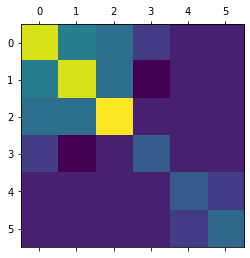

In [11]:
plt.matshow(screw_medium.elastic_tensor_voigt)

In [12]:
def make_images(mesh, medium=screw_medium, b=np.array([0,0,burgers_vector]), N_imag=10, include_center=False):
    imag_disp = np.zeros(mesh.shape[:-1] + (3,))
    for nx in range(-N_imag, N_imag + 1):
        for ny in range(-N_imag, N_imag + 1):
            if not include_center and ny == nx == 0: continue
            sign = (-1)**( (nx + ny)%2 )
            imag_disp += screw_medium.get_dislocation_displacement(mesh + [nx * lim*2 - lim/2, ny * lim*2 + 0],
                                                                    sign * b)
            imag_disp += screw_medium.get_dislocation_displacement(mesh + [nx * lim*2 + lim/2, ny * lim*2 + 0],
                                                                   -sign * b)
    return imag_disp

In [45]:
n = 100
sup_lim = lim * 5
sup_span = np.linspace(-sup_lim, sup_lim, n)
sup_mesh = np.stack(np.meshgrid(sup_span, sup_span), axis=0).reshape(2, -1).T

In [46]:
sup_imag_disp = make_images(sup_mesh, include_center=False)

In [47]:
plt.rc('figure', figsize=(20, 10))

In [48]:
import scipy.ndimage

In [53]:
def plot(mesh, disp, idx=0, levels=20, include_legend=True):
    n = int(np.sqrt(mesh.shape[0]))
    plt.contourf(*mesh.reshape(n, n, 2).T, disp.reshape(n, n, 3)[:, :, idx].T, levels=levels)
    if include_legend: plt.colorbar()

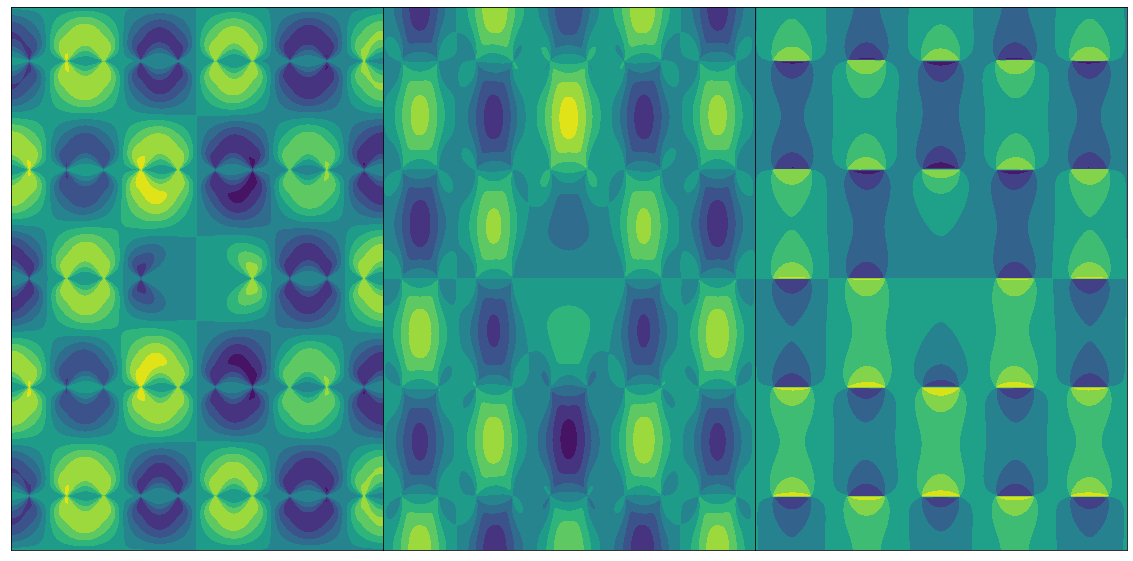

In [50]:
plt.subplot(131)
plt.xticks([])
plt.yticks([])
plot(sup_mesh, sup_imag_disp, idx=0, levels=8, include_legend=False)
plt.subplot(132, sharey=plt.gca())
plt.xticks([])
plt.yticks([])
plot(sup_mesh, sup_imag_disp, idx=1, levels=8, include_legend=False)
plt.subplot(133, sharey=plt.gca())
plt.xticks([])
plt.yticks([])
plot(sup_mesh, sup_imag_disp, idx=2, levels=8, include_legend=False)
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f'screw_array_xyz.jpg', dpi=500)

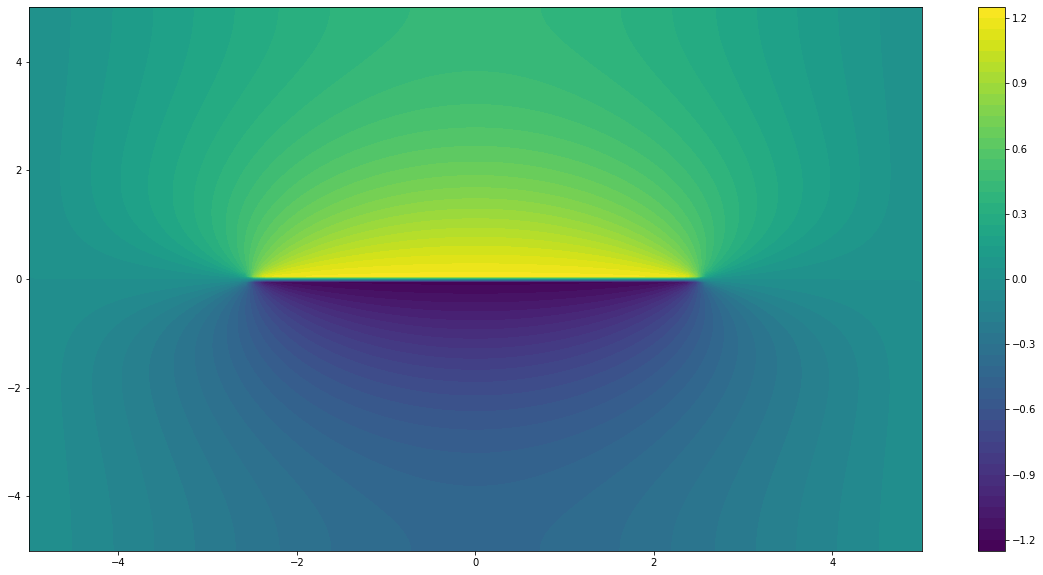

In [64]:
imag_disp = make_images(mesh, include_center=True)
plot(mesh, imag_disp, idx=2, levels=50)

In [65]:
n = int(np.sqrt(imag_disp.shape[0]))
lu_disp = imag_disp.reshape(n, n, 3)[ 0, 0 ]
ru_disp = imag_disp.reshape(n, n, 3)[ 0, -1 ]
ll_disp = imag_disp.reshape(n, n, 3)[ -1, 0 ]
rl_disp = imag_disp.reshape(n, n, 3)[ -1, -1 ]

In [66]:
lu_mesh = mesh.reshape(n, n, 2)[ 0, 0 ]
ru_mesh = mesh.reshape(n, n, 2)[ 0, -1 ]
ll_mesh = mesh.reshape(n, n, 2)[ -1, 0 ]
rl_mesh = mesh.reshape(n, n, 2)[ -1, -1 ]
lu_mesh, ru_mesh, ll_mesh, lu_mesh

(array([-5., -5.]), array([ 5., -5.]), array([-5.,  5.]), array([-5., -5.]))

In [67]:
p = np.array([0.0, 0.0])

In [68]:
U = (np.linspace(0, 1, n)[:,None,None] * (ru_disp - rl_disp)[None,None,:] + rl_disp[None,None, :]) * np.ones( (n, n, 3) )

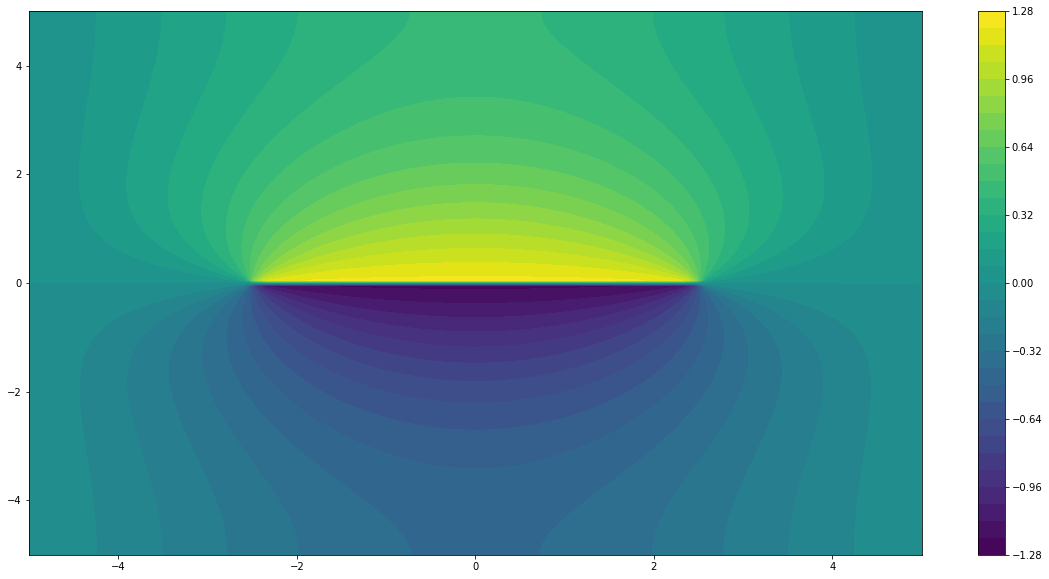

In [69]:
plot(mesh, imag_disp + U.reshape(-1, 3),idx=2,levels=30)

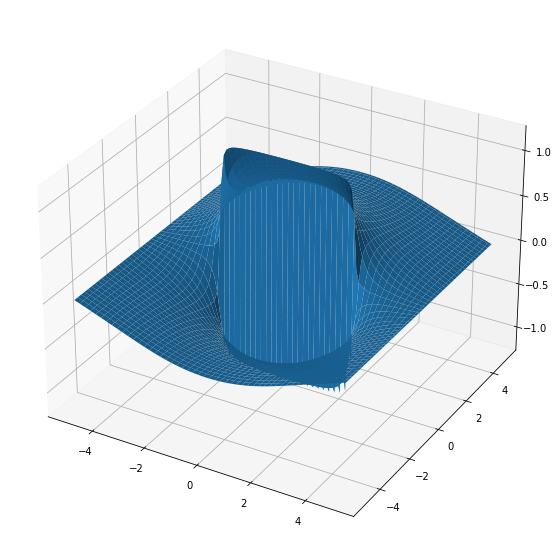

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
MM = mesh.reshape(n, n, 2)
ax.plot_surface(MM[:, :, 0], MM[:, :, 1], (imag_disp.reshape(n, n, 3) + U)[:, :, 2])

In [73]:
imag_disp = make_images(mesh, medium=edge_medium, b=edge_burgers, include_center=True)

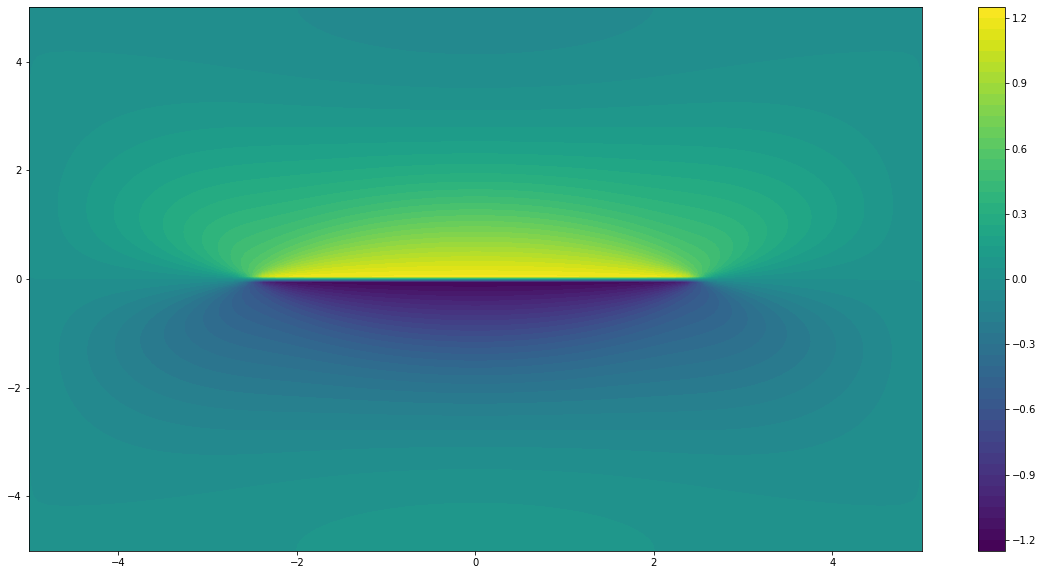

In [74]:
plot(mesh, imag_disp, idx=0, levels=50)

In [ ]:
sup_imag_disp = make_images(sup_mesh, b=edge_burgers, include_center=False)
plot(sup_mesh, sup_imag_disp, idx=0, levels=50)